In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Flatten, Input, Reshape
from keras.callbacks import EarlyStopping
from scipy.integrate import odeint 
import time

2024-11-17 10:59:43.945228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-17 10:59:44.382551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-17 10:59:44.541331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-17 10:59:44.583882: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 10:59:44.901030: I tensorflow/core/platform/cpu_feature_guar

(500, 1) (500, 1)
(8, 1) (8, 1)


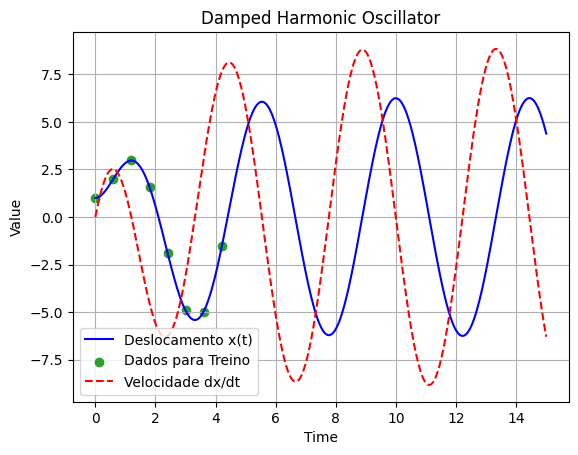

In [24]:
def damped_oscillator(y, t, zeta, omega_n, F0):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1 + F0*np.cos(omega_n*t)]
    return dydt

# Parametros
zeta = 0.4        # Damping ratio
k = 2.0
m = 1.0
omega_n = np.sqrt(k*m)    # Natural frequency
y0 = [1.0, 0.0]   # Initial conditions: [x0, v0]
F0 = 10.0
t = tf.linspace(0, 15, 500)  # Time points
t = tf.cast(t, tf.float32)

solution = odeint(damped_oscillator, y0, t, args=(zeta, omega_n, F0))


x = tf.expand_dims(t, 1)
y = tf.expand_dims(tf.cast(tf.convert_to_tensor(solution[:,0]),tf.float32),1)
print(x.shape, y.shape)

# dados para treinar a rede
#uma amostra a cada 20 pontos até o 200
x_data = x[0:160:20]
y_data = y[0:160:20] 
y_data = y_data + np.random.normal(size=y_data.shape, scale = 0.005*np.abs(y_data))
#mostra os tamanhos das matrizes
print(x_data.shape, y_data.shape)

# Plot results
plt.figure()
plt.plot(t, solution[:, 0], 'b-', label='Deslocamento x(t)')
plt.scatter(x_data, y_data, color="tab:green", label="Dados para Treino")
plt.plot(t, solution[:, 1], 'r--', label='Velocidade dx/dt')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(loc='best')
plt.title('Damped Harmonic Oscillator')
plt.grid()
plt.show()


In [25]:
# x da EDO, com 50 pontos
x_phys = tf.linspace(0,15,500)
x_phys = tf.cast(x_phys, tf.float32)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 0.00005
epochs = 30000 
k_phy_loss=(1e-1) 


#Variaveis a prever
omega_prev = tf.Variable(0.1,trainable=True,dtype=tf.float32)
zeta_prev = tf.Variable(0.1,trainable=True,dtype=tf.float32)
F0_prev = tf.Variable(0.1,trainable=True,dtype=tf.float32)


# Arquiteruta do modelo neural, usando o keras
input_dim = 1
hidden_dim = 64
hidden_dim2 = 64
output_dim = 1

model_keras=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')
model_keras.summary()

optimizer = tf.optimizers.Adam(learning_rate=learning_rate)


Model: "rede_para_PINN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
learning_rate = 0.000001
epochs = 1000000 #uns 780 seg no colab
k_phy_loss=(5e-1) # coloque zero nesta grandeza para uma FF!

@tf.function
def training_step(x_data,y_data):
    batch_X = x_data
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) 
        data_loss = tf.reduce_mean(tf.square(yh - y_data))
        with tf.GradientTape() as t2:
          t2.watch(x_phys)
          with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys) 
          dx  = t1.gradient(yhp, x_phys)
        dx2 = t2.gradient(dx, x_phys)
        physics = dx2 + 2*zeta_prev*omega_prev*dx + omega_prev**2*yhp - F0_prev*tf.cos(omega_prev*x_phys)
        Phys_loss=k_phy_loss*tf.reduce_mean(tf.square(physics))
        loss = Phys_loss + data_loss
    gradients = tape.gradient(loss, [omega_prev,zeta_prev,F0_prev]+model_keras.trainable_variables ) # Calcula os gradientes da função de perda em relação aos parâmetros do modelo e ao mu
    optimizer.apply_gradients(zip(gradients, [omega_prev,zeta_prev,F0_prev]+model_keras.trainable_variables)) #Aplica os gradientes
    return Phys_loss, data_loss, loss, [omega_prev,zeta_prev,F0_prev]


In [69]:
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
coeficientes = [] #omega,zeta,F0
start_time = time.time()
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,coef = loss
    h_loss.append(l3)
    h_data_loss.append(l2)
    h_Phys_loss.append(l1)
    coeficientes.append(coef)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l3}, Data Loss: {l2}, Physics Loss: {l1}")
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 500/1000000, Loss: 0.00011100640404038131, Data Loss: 9.794733341550454e-05, Physics Loss: 1.3059068805887364e-05
Epoch 1000/1000000, Loss: 0.00011371323489584029, Data Loss: 9.990464604925364e-05, Physics Loss: 1.3808588846586645e-05
Epoch 1500/1000000, Loss: 0.0001172311749542132, Data Loss: 0.0001035359819070436, Physics Loss: 1.3695193047169596e-05
Epoch 2000/1000000, Loss: 0.00012451292423065752, Data Loss: 0.00011045824794564396, Physics Loss: 1.405467264703475e-05
Epoch 2500/1000000, Loss: 0.00012166945089120418, Data Loss: 0.00010741970618255436, Physics Loss: 1.4249741980165709e-05
Epoch 3000/1000000, Loss: 0.0001248071203008294, Data Loss: 0.00010733597446233034, Physics Loss: 1.747114583849907e-05
Epoch 3500/1000000, Loss: 0.00012641387002076954, Data Loss: 0.00010791149543365464, Physics Loss: 1.8502376406104304e-05
Epoch 4000/1000000, Loss: 0.00012248411076143384, Data Loss: 0.00010818867303896695, Physics Loss: 1.4295444088929798e-05
Epoch 4500/1000000, Loss: 0.0001

KeyboardInterrupt: 

In [148]:
model_keras.save("Forcado1.keras")

In [71]:
t_2 = np.arange(0,15.1,0.1)

In [72]:
#tf.print(f"Omega Previsto: {coeficientes[-1][0]}, Zeta Previsto: {coeficientes[-1][1]}, F0 Previsto: {coeficientes[-1][2]}")
tf.print(f"Omega Previsto: {coeficientes[-1][0]}, Zeta Previsto: {coeficientes[-1][1]}, F0 Previsto: {coeficientes[-1][2]}")
print(f"Omega Original: {omega_n}, Zeta Original: {zeta}, F0 Original: {F0}")
prev = model_keras(np.reshape(t_2,(-1,1)))

Omega Previsto: 1.413617491722107, Zeta Previsto: 0.37934786081314087, F0 Previsto: 9.646233558654785
Omega Original: 1.4142135623730951, Zeta Original: 0.4, F0 Original: 10.0


Omega Previsto: 1.4142135381698608, Zeta Previsto: 0.39987537264823914, F0 Previsto: 9.997041702270508
Omega Original: 1.4142135623730951, Zeta Original: 0.4, F0 Original: 10.0

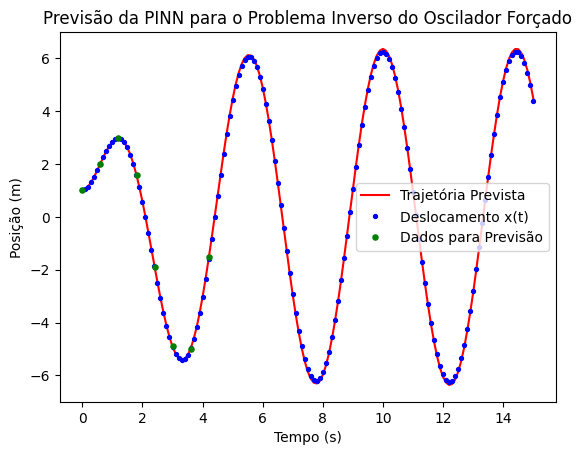

In [65]:
plt.plot(t_2,prev,"r-",markersize=2.8,label="Trajetória Prevista")
plt.plot(t_2, odeint(damped_oscillator, y0, t_2, args=(zeta, omega_n, F0))[:, 0], 'bo', label='Deslocamento x(t)',markersize=2.8)
plt.plot(x_data,y_data,"go",markersize=3.7,label="Dados para Previsão")
plt.title("Previsão da PINN para o Problema Inverso do Oscilador Forçado")
plt.xlabel("Tempo (s)")
plt.ylabel("Posição (m)")
plt.legend()
plt.savefig("imagens/forcado_pinn.png")
plt.show()